In [1]:
#class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Epithelium"]
nclasses=len(class_names)
in_channels= 3  #input channel of the data, RGB = 3



# --- training params
batch_size=256
patch_size=32 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
#validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up    

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet
from torchsummary import summary

from albumentations import *
from albumentations.pytorch import ToTensor

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob
import scipy
from tensorboardX import SummaryWriter

from tqdm.autonotebook import tqdm


import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4036MB, multi_processor_count=6)


In [18]:
class SmallNetwork(nn.Module):
    def __init__(self):
        super(SmallNetwork,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding = 1),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 6, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8)
        )


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        

        self.final= nn.Sequential(
            nn.Linear(8, 16), #--- add dropout
            nn.ReLU(True),
            nn.BatchNorm1d(16),
            nn.Linear(16, 16),
            nn.ReLU(True),
            nn.Linear(16, nclasses),
        )
                          

        
    def forward(self,x):
        x = self.encoder(x)
        #x = self.decoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x , 1)
        x = self.final(x)
        return x

In [36]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(8, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(16 * 6 * 6, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [38]:
device = torch.device('cuda')
model = AlexNet(num_classes = 7).to(device)
summary(model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 62, 62]             224
              ReLU-2            [-1, 8, 62, 62]               0
         MaxPool2d-3            [-1, 8, 30, 30]               0
            Conv2d-4           [-1, 32, 30, 30]           6,432
              ReLU-5           [-1, 32, 30, 30]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          18,496
              ReLU-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]          18,464
             ReLU-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           4,624
             ReLU-12           [-1, 16, 14, 14]               0
        MaxPool2d-13             [-1, 16, 6, 6]               0
AdaptiveAvgPool2d-14             [-1, 1

In [39]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            img = self.imgs[index,:,:,:]
            label = self.labels[index]
        
        
        img_new = img
        if self.img_transform:
            img_new = self.img_transform(image=img)['image']
        

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [40]:
img_transform={}
#img_transform["train"] = Compose([
#       VerticalFlip(p=.5),
#       HorizontalFlip(p=.5),
#       GaussNoise(),
#       GaussianBlur(),
#       #HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
#       Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
#       #ElasticTransform(always_apply=True, approximate=True, alpha=150, sigma=8,alpha_affine=50),
#       #RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
#       ToTensor()
#    ])


img_transform['train'] = Compose([
        #RandomScale(scale_limit=0.1,p=.9),
        #PadIfNeeded(min_height=patch_size,min_width=patch_size),        
        VerticalFlip(p=.5),
        HorizontalFlip(p=.5),
        #Blur(p=.5),
        #Downscale(p=.25, scale_min=0.64, scale_max=0.99),
        #GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        #GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3),
                     #  border_mode=cv2.BORDER_REFLECT),
        #ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
        RandomBrightness(p=.5, limit=(-0.2, 0.2)),
        #RandomContrast(p=.5, limit=(-0.2, 0.2)),
        #RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
        #MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
        HueSaturationValue(hue_shift_limit=20,sat_shift_limit=10,val_shift_limit=10,p=.9),
        Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
        RandomCrop(patch_size,patch_size),
        ToTensor()
    ])


img_transform["val"] = Compose([
       ToTensor()
    ])



dataname="trg"
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform[phase])
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")


train dataset size:	113000
val dataset size:	11300


0


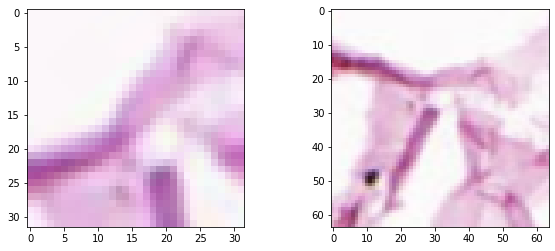

In [41]:
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["train"][100]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [42]:
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-2) 

In [43]:
class_weight= dataset["train"].classsizes
class_weight =torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 


tensor([0.8673, 0.7434, 0.8938, 0.9469, 0.7434, 0.8938, 0.9115],
       device='cuda:0')


In [44]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, label, img_orig) in tqdm(enumerate(dataLoader[phase]),total=len(dataLoader[phase])): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...nclasses)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

                writer.add_scalar(f'{phase}/batch_loss', loss.detach().cpu().numpy(), ii+batch_size*epoch)
                
                

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict()}


        torch.save(state, f"{dataname}_single_best_model.pth")
    else:
        print("")


/home/loc/.local/share/virtualenvs/DP-DFu1CsRc/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide



2m 27s (- 242m 51s) ([1/100] 1%), train loss: 1.6539 test loss: 1.4168  **



4m 55s (- 241m 30s) ([2/100] 2%), train loss: 1.4458 test loss: 1.1818  **



7m 23s (- 238m 59s) ([3/100] 3%), train loss: 1.3360 test loss: 1.3098



9m 51s (- 236m 23s) ([4/100] 4%), train loss: 1.2968 test loss: 1.1076  **



12m 19s (- 234m 6s) ([5/100] 5%), train loss: 1.2583 test loss: 1.0366  **



14m 46s (- 231m 33s) ([6/100] 6%), train loss: 1.2412 test loss: 1.0426



17m 15s (- 229m 15s) ([7/100] 7%), train loss: 1.2186 test loss: 1.0009  **



19m 43s (- 226m 45s) ([8/100] 8%), train loss: 1.1997 test loss: 0.9886  **



22m 10s (- 224m 13s) ([9/100] 9%), train loss: 1.1887 test loss: 0.9733  **



24m 39s (- 221m 50s) ([10/100] 10%), train loss: 1.1810 test loss: 1.0668



27m 6s (- 219m 19s) ([11/100] 11%), train loss: 1.1745 test loss: 0.9946



29m 34s (- 216m 49s) ([12/100] 12%), train loss: 1.1597 test loss: 0.9803



32m 1s (- 214m 19s) ([13/100] 13%), train loss: 1.1620 test loss: 0.9531  **



34m 30s (- 211m 55s) ([14/100] 14%), train loss: 1.1595 test loss: 0.9920



36m 58s (- 209m 30s) ([15/100] 15%), train loss: 1.1455 test loss: 0.9213  **



39m 26s (- 207m 5s) ([16/100] 16%), train loss: 1.1467 test loss: 0.9558



41m 54s (- 204m 35s) ([17/100] 17%), train loss: 1.1380 test loss: 0.9221



44m 21s (- 202m 5s) ([18/100] 18%), train loss: 1.1285 test loss: 0.9606



46m 49s (- 199m 38s) ([19/100] 19%), train loss: 1.1269 test loss: 0.9830



49m 18s (- 197m 11s) ([20/100] 20%), train loss: 1.1254 test loss: 0.9439



51m 45s (- 194m 42s) ([21/100] 21%), train loss: 1.1117 test loss: 0.8811  **



54m 13s (- 192m 12s) ([22/100] 22%), train loss: 1.0994 test loss: 0.9797



56m 40s (- 189m 43s) ([23/100] 23%), train loss: 1.0916 test loss: 0.9547



59m 7s (- 187m 14s) ([24/100] 24%), train loss: 1.0824 test loss: 0.9342



61m 36s (- 184m 48s) ([25/100] 25%), train loss: 1.0806 test loss: 0.8696  **



64m 4s (- 182m 21s) ([26/100] 26%), train loss: 1.0764 test loss: 0.8928



66m 33s (- 179m 55s) ([27/100] 27%), train loss: 1.0791 test loss: 0.8343  **



69m 0s (- 177m 26s) ([28/100] 28%), train loss: 1.0646 test loss: 0.8051  **



71m 28s (- 174m 57s) ([29/100] 28%), train loss: 1.0618 test loss: 0.9081



73m 55s (- 172m 29s) ([30/100] 30%), train loss: 1.0543 test loss: 0.8795



76m 24s (- 170m 3s) ([31/100] 31%), train loss: 1.0577 test loss: 0.9693



78m 52s (- 167m 36s) ([32/100] 32%), train loss: 1.0521 test loss: 1.0835



81m 21s (- 165m 9s) ([33/100] 33%), train loss: 1.0571 test loss: 0.8765



83m 49s (- 162m 41s) ([34/100] 34%), train loss: 1.0487 test loss: 0.9440



86m 16s (- 160m 13s) ([35/100] 35%), train loss: 1.0455 test loss: 0.8958



88m 44s (- 157m 45s) ([36/100] 36%), train loss: 1.0412 test loss: 0.8791



91m 11s (- 155m 16s) ([37/100] 37%), train loss: 1.0401 test loss: 0.8430



93m 39s (- 152m 48s) ([38/100] 38%), train loss: 1.0321 test loss: 0.9587



96m 7s (- 150m 20s) ([39/100] 39%), train loss: 1.0341 test loss: 0.9071



98m 34s (- 147m 51s) ([40/100] 40%), train loss: 1.0301 test loss: 0.9643



101m 2s (- 145m 23s) ([41/100] 41%), train loss: 1.0263 test loss: 0.8295



103m 31s (- 142m 57s) ([42/100] 42%), train loss: 1.0254 test loss: 0.8056



106m 0s (- 140m 30s) ([43/100] 43%), train loss: 1.0202 test loss: 0.8005  **



108m 28s (- 138m 2s) ([44/100] 44%), train loss: 1.0272 test loss: 0.9963



110m 55s (- 135m 34s) ([45/100] 45%), train loss: 1.0281 test loss: 0.9414



113m 23s (- 133m 5s) ([46/100] 46%), train loss: 1.0231 test loss: 0.8777



115m 50s (- 130m 37s) ([47/100] 47%), train loss: 1.0131 test loss: 0.8438



118m 18s (- 128m 10s) ([48/100] 48%), train loss: 1.0157 test loss: 0.8888



120m 47s (- 125m 42s) ([49/100] 49%), train loss: 1.0132 test loss: 0.7962  **



123m 14s (- 123m 14s) ([50/100] 50%), train loss: 1.0105 test loss: 0.7610  **



125m 42s (- 120m 46s) ([51/100] 51%), train loss: 1.0100 test loss: 0.7616



128m 9s (- 118m 17s) ([52/100] 52%), train loss: 1.0082 test loss: 0.8128



130m 37s (- 115m 49s) ([53/100] 53%), train loss: 1.0004 test loss: 0.8652



133m 5s (- 113m 21s) ([54/100] 54%), train loss: 1.0092 test loss: 0.9471



135m 32s (- 110m 53s) ([55/100] 55%), train loss: 1.0119 test loss: 0.9030



138m 0s (- 108m 25s) ([56/100] 56%), train loss: 1.0092 test loss: 0.9150



140m 29s (- 105m 58s) ([57/100] 56%), train loss: 1.0030 test loss: 0.7155  **



142m 57s (- 103m 31s) ([58/100] 57%), train loss: 1.0043 test loss: 0.9221



145m 25s (- 101m 3s) ([59/100] 59%), train loss: 1.0029 test loss: 0.8202



147m 52s (- 98m 35s) ([60/100] 60%), train loss: 1.0031 test loss: 1.0553



150m 20s (- 96m 7s) ([61/100] 61%), train loss: 0.9994 test loss: 0.8238



152m 48s (- 93m 39s) ([62/100] 62%), train loss: 0.9998 test loss: 0.8157



155m 16s (- 91m 11s) ([63/100] 63%), train loss: 0.9972 test loss: 0.7518



157m 45s (- 88m 44s) ([64/100] 64%), train loss: 0.9927 test loss: 0.7529



160m 14s (- 86m 16s) ([65/100] 65%), train loss: 0.9952 test loss: 0.9069



162m 41s (- 83m 48s) ([66/100] 66%), train loss: 0.9974 test loss: 0.7647



165m 9s (- 81m 20s) ([67/100] 67%), train loss: 0.9905 test loss: 0.7538



167m 37s (- 78m 52s) ([68/100] 68%), train loss: 0.9908 test loss: 0.8189



170m 4s (- 76m 24s) ([69/100] 69%), train loss: 0.9939 test loss: 0.8318



172m 33s (- 73m 56s) ([70/100] 70%), train loss: 0.9911 test loss: 0.7252



175m 1s (- 71m 29s) ([71/100] 71%), train loss: 0.9885 test loss: 0.7415



177m 29s (- 69m 1s) ([72/100] 72%), train loss: 0.9904 test loss: 0.7821



179m 56s (- 66m 33s) ([73/100] 73%), train loss: 0.9849 test loss: 0.9467



182m 25s (- 64m 5s) ([74/100] 74%), train loss: 0.9857 test loss: 0.9261



184m 54s (- 61m 37s) ([75/100] 75%), train loss: 0.9848 test loss: 0.8586



187m 22s (- 59m 10s) ([76/100] 76%), train loss: 0.9853 test loss: 0.7688



189m 50s (- 56m 42s) ([77/100] 77%), train loss: 0.9829 test loss: 0.7631



192m 18s (- 54m 14s) ([78/100] 78%), train loss: 0.9832 test loss: 0.7863



194m 46s (- 51m 46s) ([79/100] 79%), train loss: 0.9930 test loss: 0.7292



197m 15s (- 49m 18s) ([80/100] 80%), train loss: 0.9905 test loss: 0.7428



199m 43s (- 46m 50s) ([81/100] 81%), train loss: 0.9834 test loss: 0.7563



202m 10s (- 44m 22s) ([82/100] 82%), train loss: 0.9771 test loss: 0.7186



204m 39s (- 41m 54s) ([83/100] 83%), train loss: 0.9823 test loss: 0.8080



207m 7s (- 39m 26s) ([84/100] 84%), train loss: 0.9820 test loss: 0.8345



209m 34s (- 36m 58s) ([85/100] 85%), train loss: 0.9806 test loss: 0.6944  **



212m 2s (- 34m 30s) ([86/100] 86%), train loss: 0.9802 test loss: 0.7696



214m 30s (- 32m 3s) ([87/100] 87%), train loss: 0.9742 test loss: 0.8069



216m 59s (- 29m 35s) ([88/100] 88%), train loss: 0.9728 test loss: 0.6966



219m 27s (- 27m 7s) ([89/100] 89%), train loss: 0.9744 test loss: 0.6971



221m 54s (- 24m 39s) ([90/100] 90%), train loss: 0.9754 test loss: 0.9239



224m 22s (- 22m 11s) ([91/100] 91%), train loss: 0.9789 test loss: 0.7297



226m 49s (- 19m 43s) ([92/100] 92%), train loss: 0.9727 test loss: 0.7264



229m 18s (- 17m 15s) ([93/100] 93%), train loss: 0.9718 test loss: 0.7067



231m 46s (- 14m 47s) ([94/100] 94%), train loss: 0.9764 test loss: 0.7669



234m 14s (- 12m 19s) ([95/100] 95%), train loss: 0.9743 test loss: 0.7211



236m 41s (- 9m 51s) ([96/100] 96%), train loss: 0.9753 test loss: 0.8469



239m 9s (- 7m 23s) ([97/100] 97%), train loss: 0.9719 test loss: 0.7634



241m 37s (- 4m 55s) ([98/100] 98%), train loss: 0.9762 test loss: 0.8312



244m 4s (- 2m 27s) ([99/100] 99%), train loss: 0.9702 test loss: 0.7375



246m 33s (- -1m 59s) ([100/100] 100%), train loss: 0.9730 test loss: 0.7612


In [26]:
!tensorboard --logdir runs 

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.0.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
